# Assignment_Forecast_Arlines_Passengers

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

C:\Users\PRASAD\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# Import Dataset
df = pd.read_excel('Airlines+Data.xlsx')
print('Shape of the data',df.shape)
df.head()

Shape of the data (96, 2)


,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


### Data Exploration

In [3]:
df.isnull().any()

Month         False
Passengers    False
dtype: bool

In [4]:
df.isnull().sum()

Month         0
Passengers    0
dtype: int64

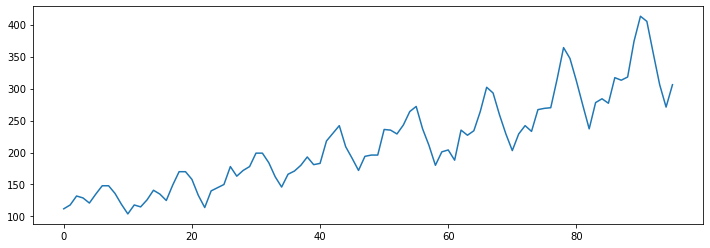

In [5]:
df.Passengers.plot(figsize=(12,4))

### Descriptive Analysis

In [6]:
#Checking the data types
df.dtypes

Month         datetime64[ns]
Passengers             int64
dtype: object

In [7]:
#Unique values for every feature
df.nunique()

Month         96
Passengers    80
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [9]:
df[df.duplicated()].shape

(0, 2)

In [10]:
df[df.duplicated()]

,Month,Passengers


In [11]:
df.describe()

,Passengers
count,96.000000
mean,213.708333
std,71.918216
min,104.000000
25%,156.000000
50%,200.000000
75%,264.750000
max,413.000000


### Feature Engineering

In [12]:
df.rename({'Month':'Date'},axis=1, inplace=True)

In [13]:
# Making the Date as DateTime index for the Dataframe
df1 = df.copy()
df1.set_index('Date',inplace=True)
df1.index.year

Int64Index([1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995,
            1995, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996,
            1996, 1996, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997,
            1997, 1997, 1997, 1998, 1998, 1998, 1998, 1998, 1998, 1998, 1998,
            1998, 1998, 1998, 1998, 1999, 1999, 1999, 1999, 1999, 1999, 1999,
            1999, 1999, 1999, 1999, 1999, 2000, 2000, 2000, 2000, 2000, 2000,
            2000, 2000, 2000, 2000, 2000, 2000, 2001, 2001, 2001, 2001, 2001,
            2001, 2001, 2001, 2001, 2001, 2001, 2001, 2002, 2002, 2002, 2002,
            2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002],
           dtype='int64', name='Date')

In [14]:
# Separating Month and Year into Separate Column for Visualization and removing meaningful insight of the data
df["Date"] = pd.to_datetime(df.Date,format="%b-%y")
df["month"] = df.Date.dt.strftime("%b") # month extraction
df["year"] = df.Date.dt.strftime("%Y") # year extraction
df.head()

,Date,Passengers,month,year
0,1995-01-01,112,Jan,1995
1,1995-02-01,118,Feb,1995
2,1995-03-01,132,Mar,1995
3,1995-04-01,129,Apr,1995
4,1995-05-01,121,May,1995


####  Data Visualization

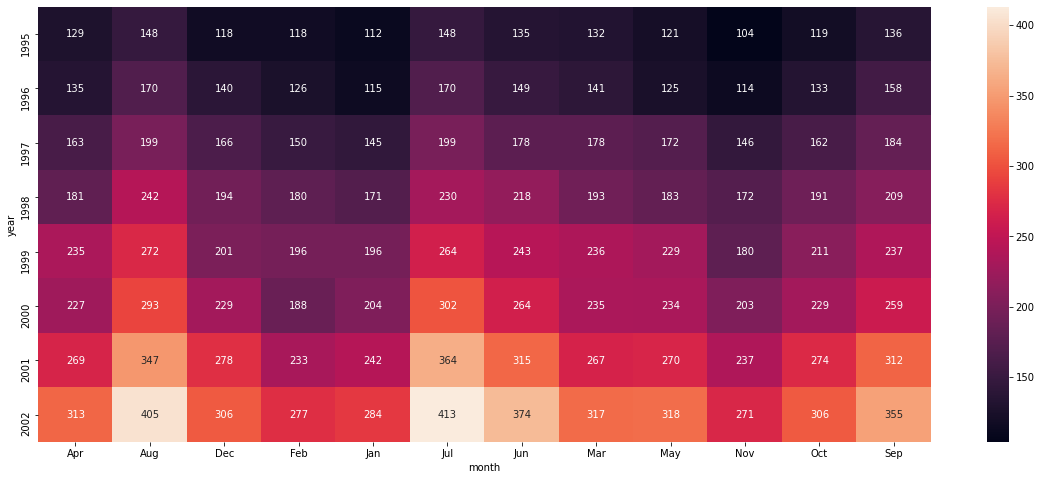

In [15]:
plt.figure(figsize=(20,8))
heatmap_y_month = pd.pivot_table(data=df,values="Passengers",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g") #fmt is format of the grid values

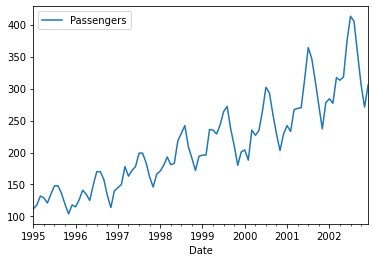

In [16]:
# Line plot
df1.plot()
plt.show()

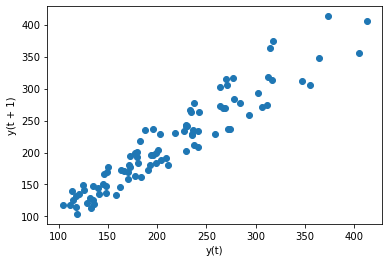

In [17]:
##Lag_plot
from pandas.plotting import lag_plot

lag_plot(df1)
plt.show()

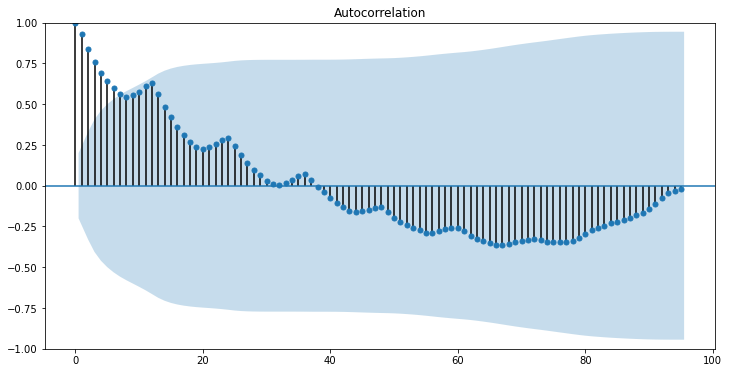

In [19]:
import statsmodels.graphics.tsaplots as tsa_plots

with plt.rc_context():
    plt.rc("figure", figsize=(12,6))
    tsa_plots.plot_acf(df.Passengers,lags=95)
    plt.show()

#### Partial Autocorrelation Function (PACF)

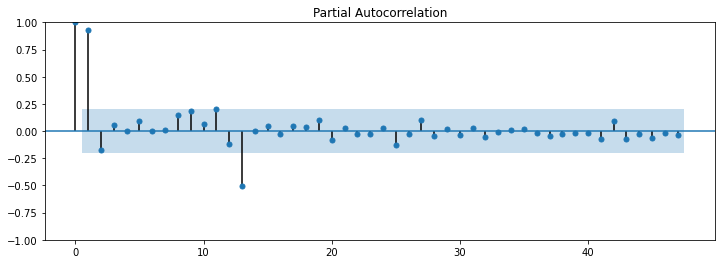

In [20]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,4))
    tsa_plots.plot_pacf(df.Passengers,lags=47)
    plt.show()

### Splitting Train and Test Data

In [21]:
# Leaving Test Data with 2 Years of Time Series
size = 72
train_data = df1[:size]
test_data = df1[size:]

In [22]:
print('Train:',train_data.index.min(),train_data.index.max(),'\n',
'Test:',test_data.index.min(),test_data.index.max())

Train: 1995-01-01 00:00:00 2000-12-01 00:00:00 
 Test: 2001-01-01 00:00:00 2002-12-01 00:00:00


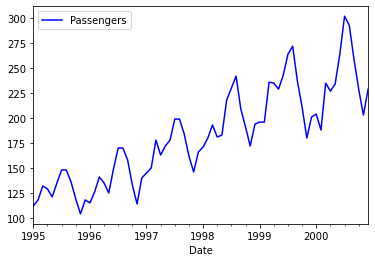

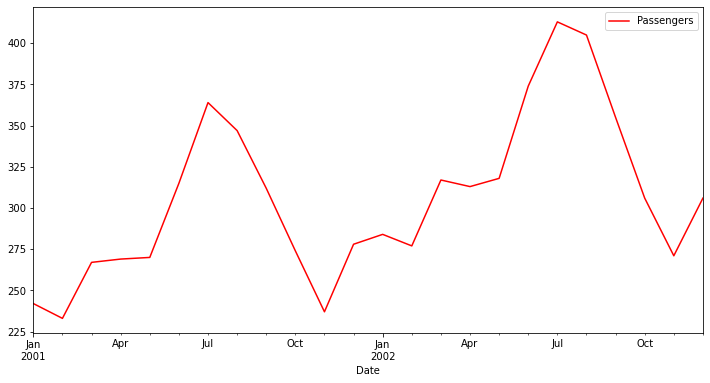

In [23]:
# We are going to forecast for the last two years. 2001 and 2002.
# Last 24 records contain From 2001 to 2002 data.

train_data.plot(legend=True,label='TRAIN',color='blue')
test_data.plot(legend=True,label='TEST', figsize=(12,6),color='red')

### UpSampling

In [24]:
upsampled = df1.resample('M').mean()
print(upsampled.head(32))

            Passengers
Date                  
1995-01-31       112.0
1995-02-28       118.0
1995-03-31       132.0
1995-04-30       129.0
1995-05-31       121.0
1995-06-30       135.0
1995-07-31       148.0
1995-08-31       148.0
1995-09-30       136.0
1995-10-31       119.0
1995-11-30       104.0
1995-12-31       118.0
1996-01-31       115.0
1996-02-29       126.0
1996-03-31       141.0
1996-04-30       135.0
1996-05-31       125.0
1996-06-30       149.0
1996-07-31       170.0
1996-08-31       170.0
1996-09-30       158.0
1996-10-31       133.0
1996-11-30       114.0
1996-12-31       140.0
1997-01-31       145.0
1997-02-28       150.0
1997-03-31       178.0
1997-04-30       163.0
1997-05-31       172.0
1997-06-30       178.0
1997-07-31       199.0
1997-08-31       199.0


            Passengers
Date                  
1995-01-31       112.0
1995-02-28       118.0
1995-03-31       132.0
1995-04-30       129.0
1995-05-31       121.0
1995-06-30       135.0
1995-07-31       148.0
1995-08-31       148.0
1995-09-30       136.0
1995-10-31       119.0
1995-11-30       104.0
1995-12-31       118.0
1996-01-31       115.0
1996-02-29       126.0
1996-03-31       141.0


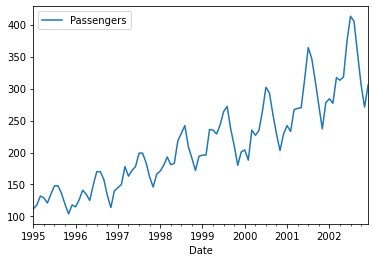

In [25]:
interpolated = upsampled.interpolate(method='linear') ## interplation was done for nan values which we get after doing upsampling by month
print(interpolated.head(15))
interpolated.plot()
plt.show()

### Tranformations

#### Square Root Transform

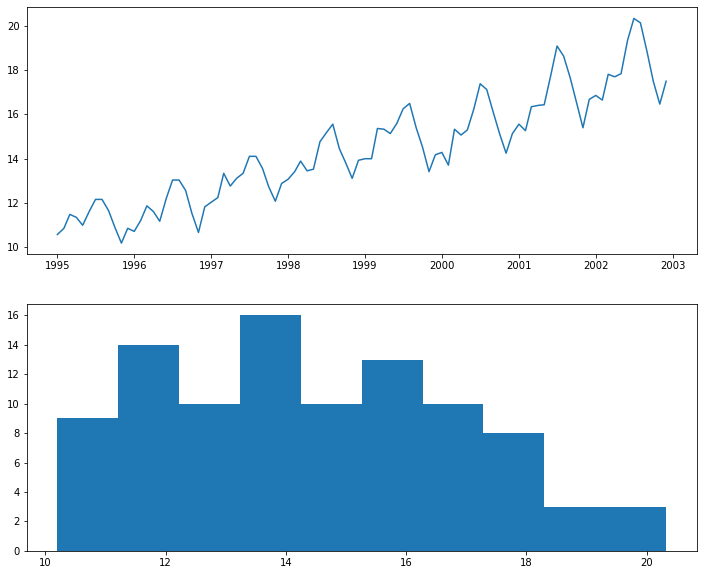

In [26]:
# Square Root Transform
square_root= pd.DataFrame()
square_root = df1[['Passengers']]
square_root['Passengers'] = np.sqrt(square_root.Passengers)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(square_root['Passengers'])
#Histogram
plt.subplot(212)
plt.hist(square_root['Passengers'])
plt.show()

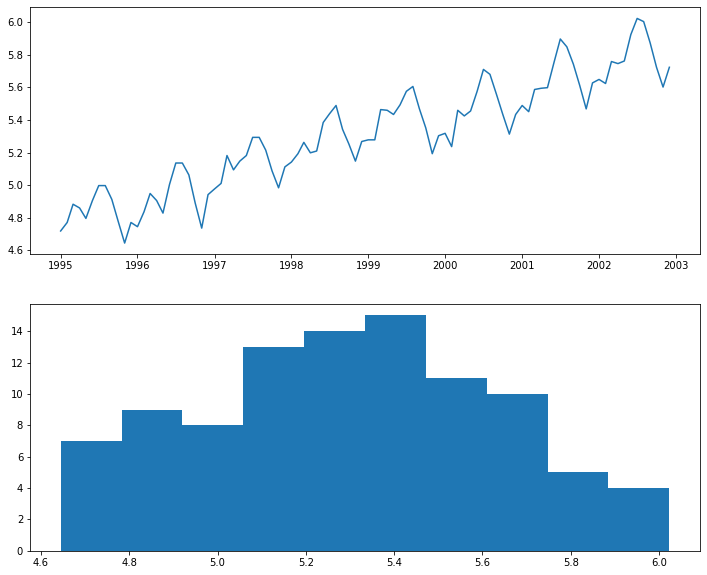

In [27]:
# Log Transform
log = pd.DataFrame()
log = df1[['Passengers']]
log['Passengers'] = np.log(log.Passengers)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(log['Passengers'])
#Histogram
plt.subplot(212)
plt.hist(log['Passengers'])
plt.show()

In [28]:
Train = interpolated.head(81)
Test = interpolated.tail(14)

### Moving Average

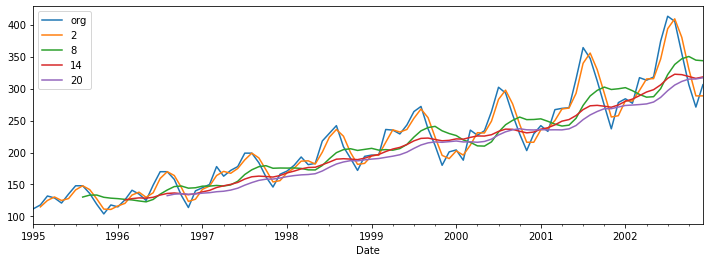

In [29]:
# Moving Average
plt.figure(figsize=(12,4))
interpolated.Passengers.plot(label="org")
for i in range(2,24,6):
    interpolated["Passengers"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

### Time Series Decomposition

#### Additive Seasonal Decomposition

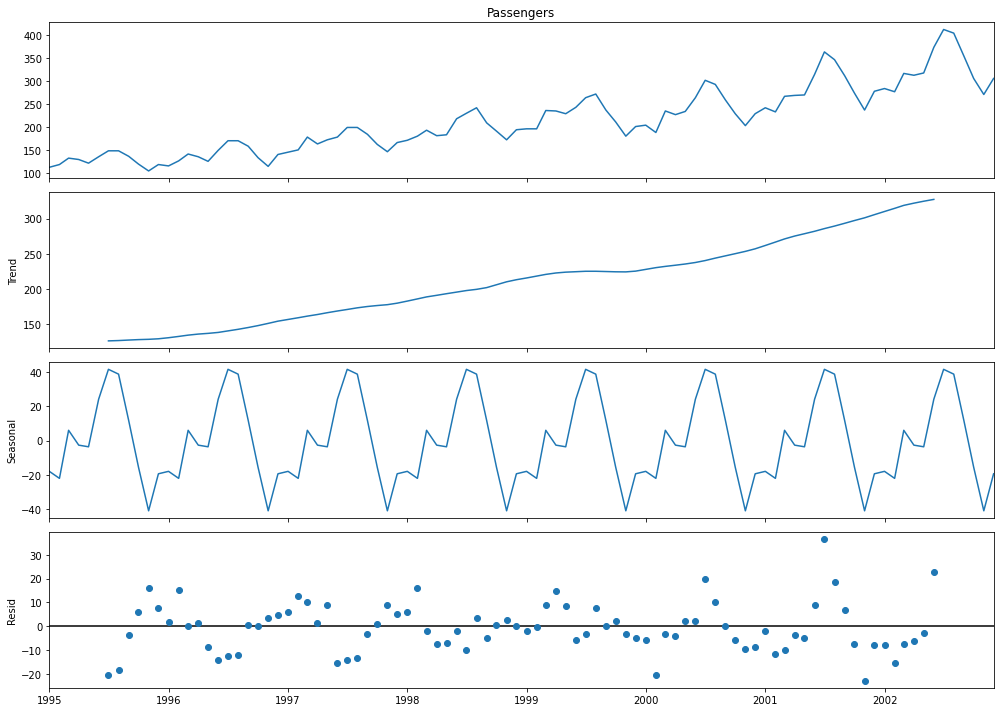

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_ts_add = seasonal_decompose(df1.Passengers,period=12, model='additive')
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

##### Multiplicative Seasonal Decomposition

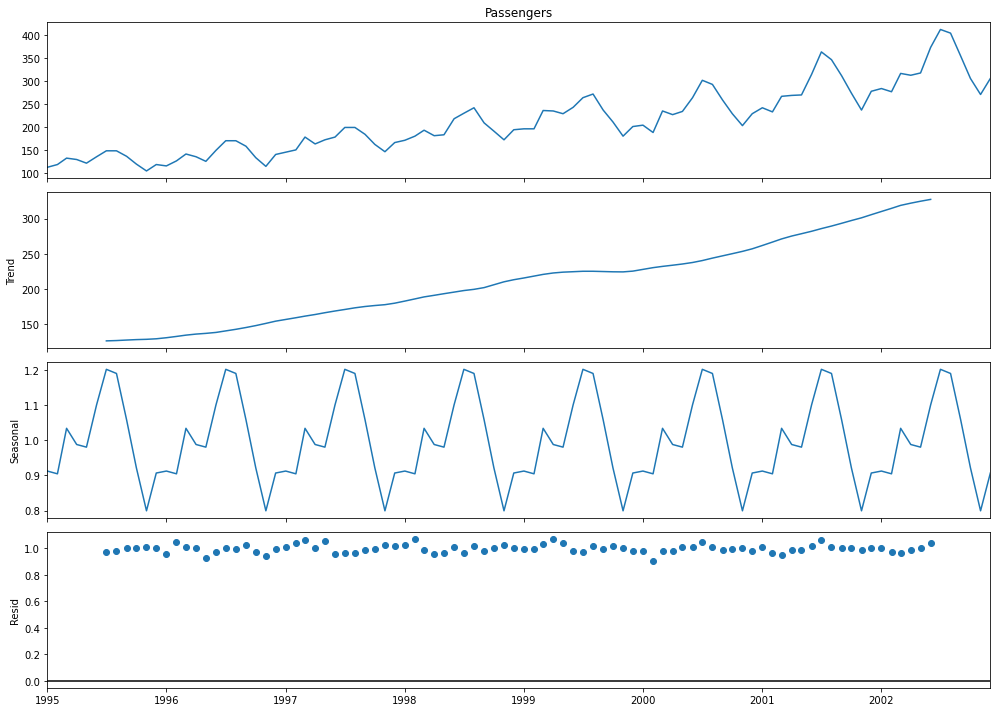

In [31]:
decompose_ts_add = seasonal_decompose(df1.Passengers,period=12, model='multiplicative')
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

#### ACF plots and PACF plots

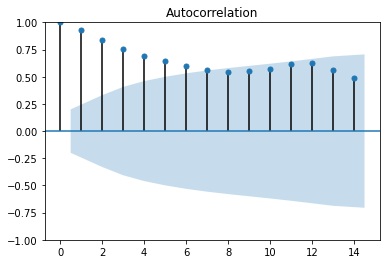

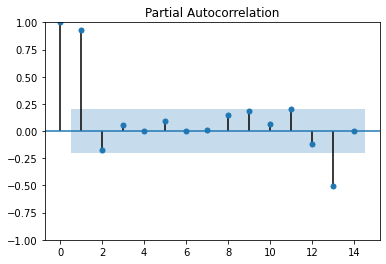

In [32]:
import statsmodels.graphics.tsaplots as tsa_plots

tsa_plots.plot_acf(interpolated.Passengers,lags=14)
tsa_plots.plot_pacf(interpolated.Passengers,lags=14)
plt.show()

#### Evaluation Metric MAPE

In [33]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

### Simple Exponential Method

In [34]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from math import sqrt

ses_model = SimpleExpSmoothing(Train["Passengers"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_ses,Test.Passengers)

11.894852606792627

#### Holt method

In [35]:
# Holt method 
from statsmodels.tsa.holtwinters import Holt

hw_model = Holt(Train["Passengers"]).fit(smoothing_level=0.1, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hw,Test.Passengers)

15.722798256076471

#### Holts winter exponential smoothing with additive seasonality and additive trend

In [36]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

hwe_model_add_add = ExponentialSmoothing(Train["Passengers"],seasonal="add",trend="add",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.2) #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_add_add,Test.Passengers)

3.5048104545232412

#### Holts winter exponential smoothing with multiplicative seasonality and additive trend`

In [37]:
hwe_model_mul_add = ExponentialSmoothing(Train["Passengers"],seasonal="mul",
                                         trend="add",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.2) 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_mul_add,Test.Passengers)

2.4005341356325838

In [38]:
rmse_hwe_mul_add = sqrt(mean_squared_error(pred_hwe_mul_add,Test.Passengers))
rmse_hwe_mul_add

10.235219228649234

In [39]:
# Final Model by combining train and test

In [40]:
hwe_model_add_add = ExponentialSmoothing(interpolated["Passengers"],seasonal="add",trend="add",seasonal_periods=10).fit()

In [41]:
#Forecasting for next 10 time periods
hwe_model_add_add.forecast(10)

2003-01-31    313.478967
2003-02-28    318.530032
2003-03-31    320.728270
2003-04-30    320.896176
2003-05-31    321.940294
2003-06-30    321.098732
2003-07-31    316.590461
2003-08-31    318.631108
2003-09-30    318.621787
2003-10-31    327.512226
Freq: M, dtype: float64

In [42]:
interpolated.head()

,Passengers
Date,
1995-01-31,112.0
1995-02-28,118.0
1995-03-31,132.0
1995-04-30,129.0
1995-05-31,121.0


In [43]:
interpolated.reset_index(inplace=True)

In [44]:
interpolated['t'] = 1
interpolated

,Date,Passengers,t
0,1995-01-31,112.0,1
1,1995-02-28,118.0,1
2,1995-03-31,132.0,1
3,1995-04-30,129.0,1
4,1995-05-31,121.0,1
...,...,...,...
91,2002-08-31,405.0,1
92,2002-09-30,355.0,1
93,2002-10-31,306.0,1
94,2002-11-30,271.0,1


In [45]:
for i,row in interpolated.iterrows():
  interpolated['t'].iloc[i] = i+1

interpolated

,Date,Passengers,t
0,1995-01-31,112.0,1
1,1995-02-28,118.0,2
2,1995-03-31,132.0,3
3,1995-04-30,129.0,4
4,1995-05-31,121.0,5
...,...,...,...
91,2002-08-31,405.0,92
92,2002-09-30,355.0,93
93,2002-10-31,306.0,94
94,2002-11-30,271.0,95


In [46]:
interpolated['t_sq'] = (interpolated['t'])**2
## inserted t_sq column with values
interpolated

,Date,Passengers,t,t_sq
0,1995-01-31,112.0,1,1
1,1995-02-28,118.0,2,4
2,1995-03-31,132.0,3,9
3,1995-04-30,129.0,4,16
4,1995-05-31,121.0,5,25
...,...,...,...,...
91,2002-08-31,405.0,92,8464
92,2002-09-30,355.0,93,8649
93,2002-10-31,306.0,94,8836
94,2002-11-30,271.0,95,9025


In [47]:
interpolated["month"] = interpolated.Date.dt.strftime("%b") # month extraction
interpolated["year"] = interpolated.Date.dt.strftime("%Y") # month extraction

In [48]:
interpolated

,Date,Passengers,t,t_sq,month,year
0,1995-01-31,112.0,1,1,Jan,1995
1,1995-02-28,118.0,2,4,Feb,1995
2,1995-03-31,132.0,3,9,Mar,1995
3,1995-04-30,129.0,4,16,Apr,1995
4,1995-05-31,121.0,5,25,May,1995
...,...,...,...,...,...,...
91,2002-08-31,405.0,92,8464,Aug,2002
92,2002-09-30,355.0,93,8649,Sep,2002
93,2002-10-31,306.0,94,8836,Oct,2002
94,2002-11-30,271.0,95,9025,Nov,2002


In [49]:
months = pd.get_dummies(interpolated['month']) ## converting the dummy variables for month column
months

,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
91,0,1,0,0,0,0,0,0,0,0,0,0
92,0,0,0,0,0,0,0,0,0,0,0,1
93,0,0,0,0,0,0,0,0,0,0,1,0
94,0,0,0,0,0,0,0,0,0,1,0,0


In [50]:
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
## storing the months as serial wise again in months variable

In [51]:
Airlines = pd.concat([interpolated,months],axis=1)
Airlines = pd.concat([interpolated,months],axis=1)

In [52]:
Airlines['log_passengers'] = np.log(Airlines['Passengers'])

In [53]:
Airlines

,Date,Passengers,t,t_sq,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_passengers
0,1995-01-31,112.0,1,1,Jan,1995,1,0,0,0,0,0,0,0,0,0,0,0,4.718499
1,1995-02-28,118.0,2,4,Feb,1995,0,1,0,0,0,0,0,0,0,0,0,0,4.770685
2,1995-03-31,132.0,3,9,Mar,1995,0,0,1,0,0,0,0,0,0,0,0,0,4.882802
3,1995-04-30,129.0,4,16,Apr,1995,0,0,0,1,0,0,0,0,0,0,0,0,4.859812
4,1995-05-31,121.0,5,25,May,1995,0,0,0,0,1,0,0,0,0,0,0,0,4.795791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2002-08-31,405.0,92,8464,Aug,2002,0,0,0,0,0,0,0,1,0,0,0,0,6.003887
92,2002-09-30,355.0,93,8649,Sep,2002,0,0,0,0,0,0,0,0,1,0,0,0,5.872118
93,2002-10-31,306.0,94,8836,Oct,2002,0,0,0,0,0,0,0,0,0,1,0,0,5.723585
94,2002-11-30,271.0,95,9025,Nov,2002,0,0,0,0,0,0,0,0,0,0,1,0,5.602119


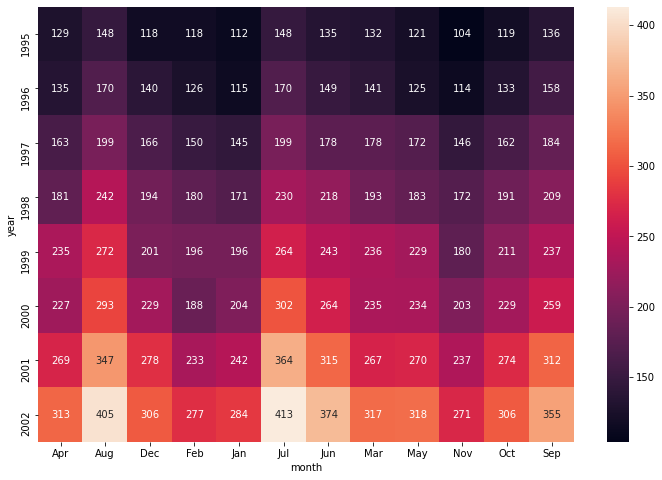

In [54]:
plt.figure(figsize=(12,8))
heatmap_y_month = pd.pivot_table(data=Airlines,values="Passengers",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g")

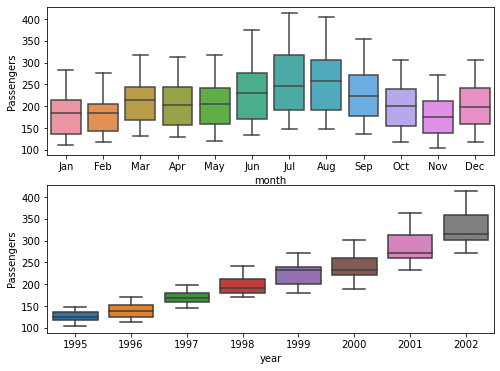

In [55]:
# Boxplot 
plt.figure(figsize=(8,6))
plt.subplot(211)
sns.boxplot(x="month",y="Passengers",data= Airlines)
plt.subplot(212)
sns.boxplot(x="year",y="Passengers",data=Airlines)


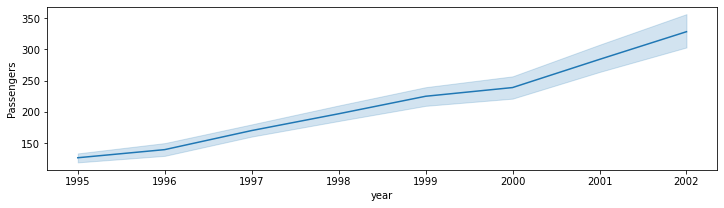

In [56]:
plt.figure(figsize=(12,3))
sns.lineplot(x="year",y="Passengers",data=Airlines)

### Splitting data

In [57]:
Train = Airlines.head(81) # training data
Test = Airlines.tail(14) # test Data

In [58]:
#Linear Model
import statsmodels.formula.api as smf 

linear_model = smf.ols('Passengers~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_linear))**2))
rmse_linear

49.48379883520373

In [59]:
#Exponential
Exp = smf.ols('log_passengers~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

46.29168664671047

In [60]:
#Quadratic 

Quad = smf.ols('Passengers~t+t_sq',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_sq"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_Quad))**2))
rmse_Quad

46.23045842456938

In [61]:
#Additive seasonality 

add_sea = smf.ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea))**2))
rmse_add_sea

130.73813565673314

In [62]:
#Additive Seasonality Quadratic 

add_sea_Quad = smf.ols('Passengers~t+t_sq+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','t','t_sq']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

24.0868610780056

In [63]:
##Multiplicative Seasonality

Mul_sea = smf.ols('log_passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

137.188551058474

In [64]:
#Multiplicative Additive Seasonality 

Mul_Add_sea = smf.ols('log_passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea

9.914858786222235

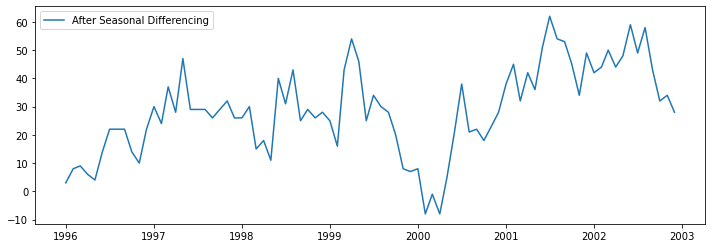

In [65]:
### seasonal differencing
seasonal_differencing = df1 - df1.shift(12)
seasonal_differencing.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(seasonal_differencing, label='After Seasonal Differencing')
plt.legend(loc='best')
plt.show()

In [66]:
#Compareing the results 

data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
6,rmse_Mult_add_sea,9.914859
4,rmse_add_sea_quad,24.086861
2,rmse_Quad,46.230458
1,rmse_Exp,46.291687
0,rmse_linear,49.483799
3,rmse_add_sea,130.738136
5,rmse_Mult_sea,137.188551
